In [3]:
!pip install opendatasets


In [4]:

import opendatasets as od
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [5]:
od.download("https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: matearevadze
Your Kaggle Key: ··········


100%|██████████| 2.70M/2.70M [00:00<00:00, 785MB/s]


Extracting archive ./walmart-recruiting-store-sales-forecasting/walmart-recruiting-store-sales-forecasting.zip to ./walmart-recruiting-store-sales-forecasting


In [6]:

train_data = pd.read_csv("/content/walmart-recruiting-store-sales-forecasting/train.csv.zip")
features_data = pd.read_csv("/content/walmart-recruiting-store-sales-forecasting/features.csv.zip")

train_data['Date'] = pd.to_datetime(train_data['Date'])
features_data['Date'] = pd.to_datetime(features_data['Date'])
features_data.drop(['IsHoliday'], axis=1, inplace=True)
stores_data = pd.read_csv("/content/walmart-recruiting-store-sales-forecasting/stores.csv")
merged_data = pd.merge(train_data, features_data, on=['Store', 'Date'], how='left')
data = pd.merge(merged_data, stores_data, on='Store', how='left')

merged_data = merged_data.rename(columns={'IsHoliday_x': 'IsHoliday'})



In [7]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class HolidayDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        date_col='Date',
        holiday_col='IsHoliday',
        type_col='Type',
        group_cols=['Store', 'Dept'],
        lags=[1, 2],
        rolling_windows=[4]
    ):
        self.date_col = date_col
        self.holiday_col = holiday_col
        self.type_col = type_col
        self.group_cols = group_cols
        self.lags = lags
        self.rolling_windows = rolling_windows
        self.type_encoder = LabelEncoder()

    def fit(self, X, y=None):
        if self.type_col in X.columns:
            self.type_encoder.fit(X[self.type_col].astype(str))
        return self

    def transform(self, X):
        X = X.copy()

        # Convert columns
        X[self.holiday_col] = X[self.holiday_col].astype(int)
        X[self.date_col] = pd.to_datetime(X[self.date_col])
        X['Year'] = X[self.date_col].dt.year
        X['Month'] = X[self.date_col].dt.month
        X['Day'] = X[self.date_col].dt.day
        X['DayOfWeek'] = X[self.date_col].dt.dayofweek
        X['WeekOfYear'] = X[self.date_col].dt.isocalendar().week

        # Encode 'Type'
        if self.type_col in X.columns:
            X[self.type_col] = self.type_encoder.transform(X[self.type_col].astype(str))

        # Sort before group-based transforms
        X = X.sort_values(self.group_cols + [self.date_col])

        # Generate lag features
        for lag in self.lags:
            X[f'Lag_{lag}'] = X.groupby(self.group_cols)['Weekly_Sales'].shift(lag)

        # Generate rolling features
        for window in self.rolling_windows:
            X[f'RollingMean_{window}'] = (
                X.groupby(self.group_cols)['Weekly_Sales']
                .shift(1)
                .rolling(window)
                .mean()
                .reset_index(drop=True)
            )
            X[f'RollingStd_{window}'] = (
                X.groupby(self.group_cols)['Weekly_Sales']
                .shift(1)
                .rolling(window)
                .std()
                .reset_index(drop=True)

            )

        # Drop columns not used
        cols_to_drop = [self.date_col]
        X = X.drop(columns=[col for col in cols_to_drop if col in X.columns])

        return X




In [8]:
total = data.isnull().sum().sort_values(ascending=False)
percent = ((data.isnull().sum()/data.isnull().count()) * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,310322,73.611025
MarkDown4,286603,67.984676
MarkDown3,284479,67.480845
MarkDown1,270889,64.257181
MarkDown5,270138,64.079038
Store,0,0.000000
Date,0,0.000000
Dept,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


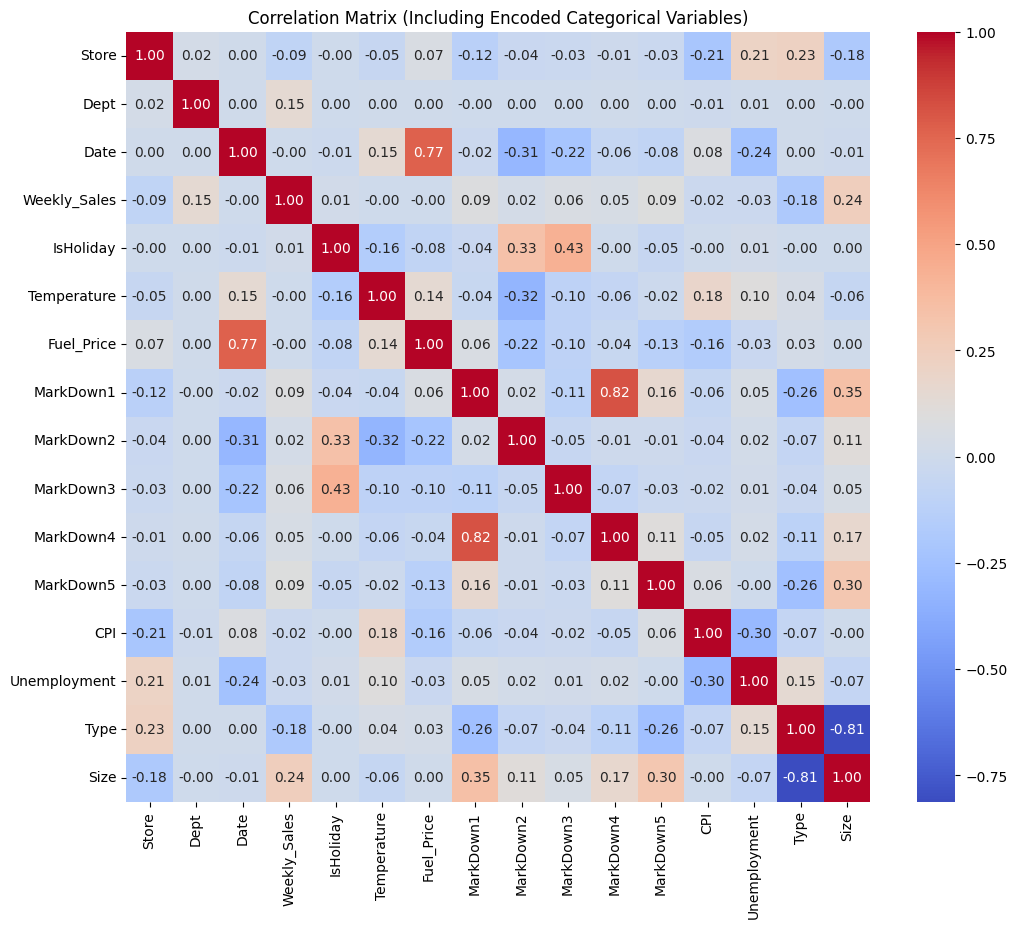

In [9]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the data to avoid modifying the original
encoded_data = data.copy()

# Encode all object/categorical columns
for col in encoded_data.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col].astype(str))

import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = encoded_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Including Encoded Categorical Variables)')
plt.show()


In [10]:
y = data['Weekly_Sales']
X = data

In [13]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('holiday_date', HolidayDateTransformer())
])

X_processed = pipeline.fit_transform(X)
X_processed.drop(['Weekly_Sales'], axis=1, inplace=True)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, shuffle=False
)


In [15]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
from sklearn.metrics import mean_squared_error

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

weights_val = np.where(X_val['IsHoliday'] == 1, 5, 1)
weights_train = np.where(X_train['IsHoliday'] == 1, 5, 1)

wmae_validation = np.sum(weights_val * np.abs(y_val - y_val_pred)) / np.sum(weights_val)
wmae_train = np.sum(weights_train * np.abs(y_train - y_train_pred)) / np.sum(weights_train)

print(f"Weighted Mean Absolute Error (WMAE) on Validation Set: {wmae_validation}")
print(f"Weighted Mean Absolute Error (WMAE) on Training Set: {wmae_train}")

Weighted Mean Absolute Error (WMAE) on Validation Set: 1320.8792745397427
Weighted Mean Absolute Error (WMAE) on Training Set: 1459.3052264602131


In [22]:
pip install mlflow


In [23]:
pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 8.0 MB/s eta 0:00:00


In [24]:
import mlflow
import dagshub

dagshub.init(repo_owner='CarlTeapot', repo_name='Walmart-recruiting', mlflow=True)


name = "XGBoost model for walmart recruiting competition"


with mlflow.start_run(run_name = name):
          mlflow.log_metric("WMAE_Validation", wmae_validation)
          mlflow.log_metric("WMAE_Train", wmae_train)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=73d2563a-387a-41b8-b3ac-75121998f64c&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=7464f30c6219e78a94c70ad564b80677fc5668e2dd78ee824b0a270bca8d2571




Accessing as CarlTeapot

Initialized MLflow to track repo "CarlTeapot/Walmart-recruiting"

Repository CarlTeapot/Walmart-recruiting initialized!

🏃 View run XGBoost model for walmart recruiting competition at: https://dagshub.com/CarlTeapot/Walmart-recruiting.mlflow/#/experiments/0/runs/59c5cfd99cc840c094a3cc9c025fd8e6
🧪 View experiment at: https://dagshub.com/CarlTeapot/Walmart-recruiting.mlflow/#/experiments/0


In [26]:
nbstripout model_experiment_xgboost.ipynb


SyntaxError: invalid syntax (ipython-input-26-1615138169.py, line 1)